In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
import scikitplot as skplt
import pickle
import seaborn as sns


# I - Préparation des Données 

   longitude   latitude  haut_tot  haut_tronc  tronc_diam feuillage  \
0   3.293264  49.840500       6.0         2.0        37.0   Feuillu   
1   3.273380  49.861409      13.0         1.0       160.0  Conifère   
2   3.289068  49.844513      12.0         3.0       116.0   Feuillu   
3   3.302387  49.861778      16.0         3.0       150.0   Feuillu   
4   3.304047  49.858446       5.0         2.0       170.0   Feuillu   

  fk_arb_etat  age_estim  
0    EN PLACE       15.0  
1    EN PLACE       50.0  
2    REMPLACÉ       30.0  
3    EN PLACE       50.0  
4    Essouché       40.0  


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'haut_tot'}>,
        <Axes: title={'center': 'haut_tronc'}>],
       [<Axes: title={'center': 'tronc_diam'}>,
        <Axes: title={'center': 'age_estim'}>]], dtype=object)

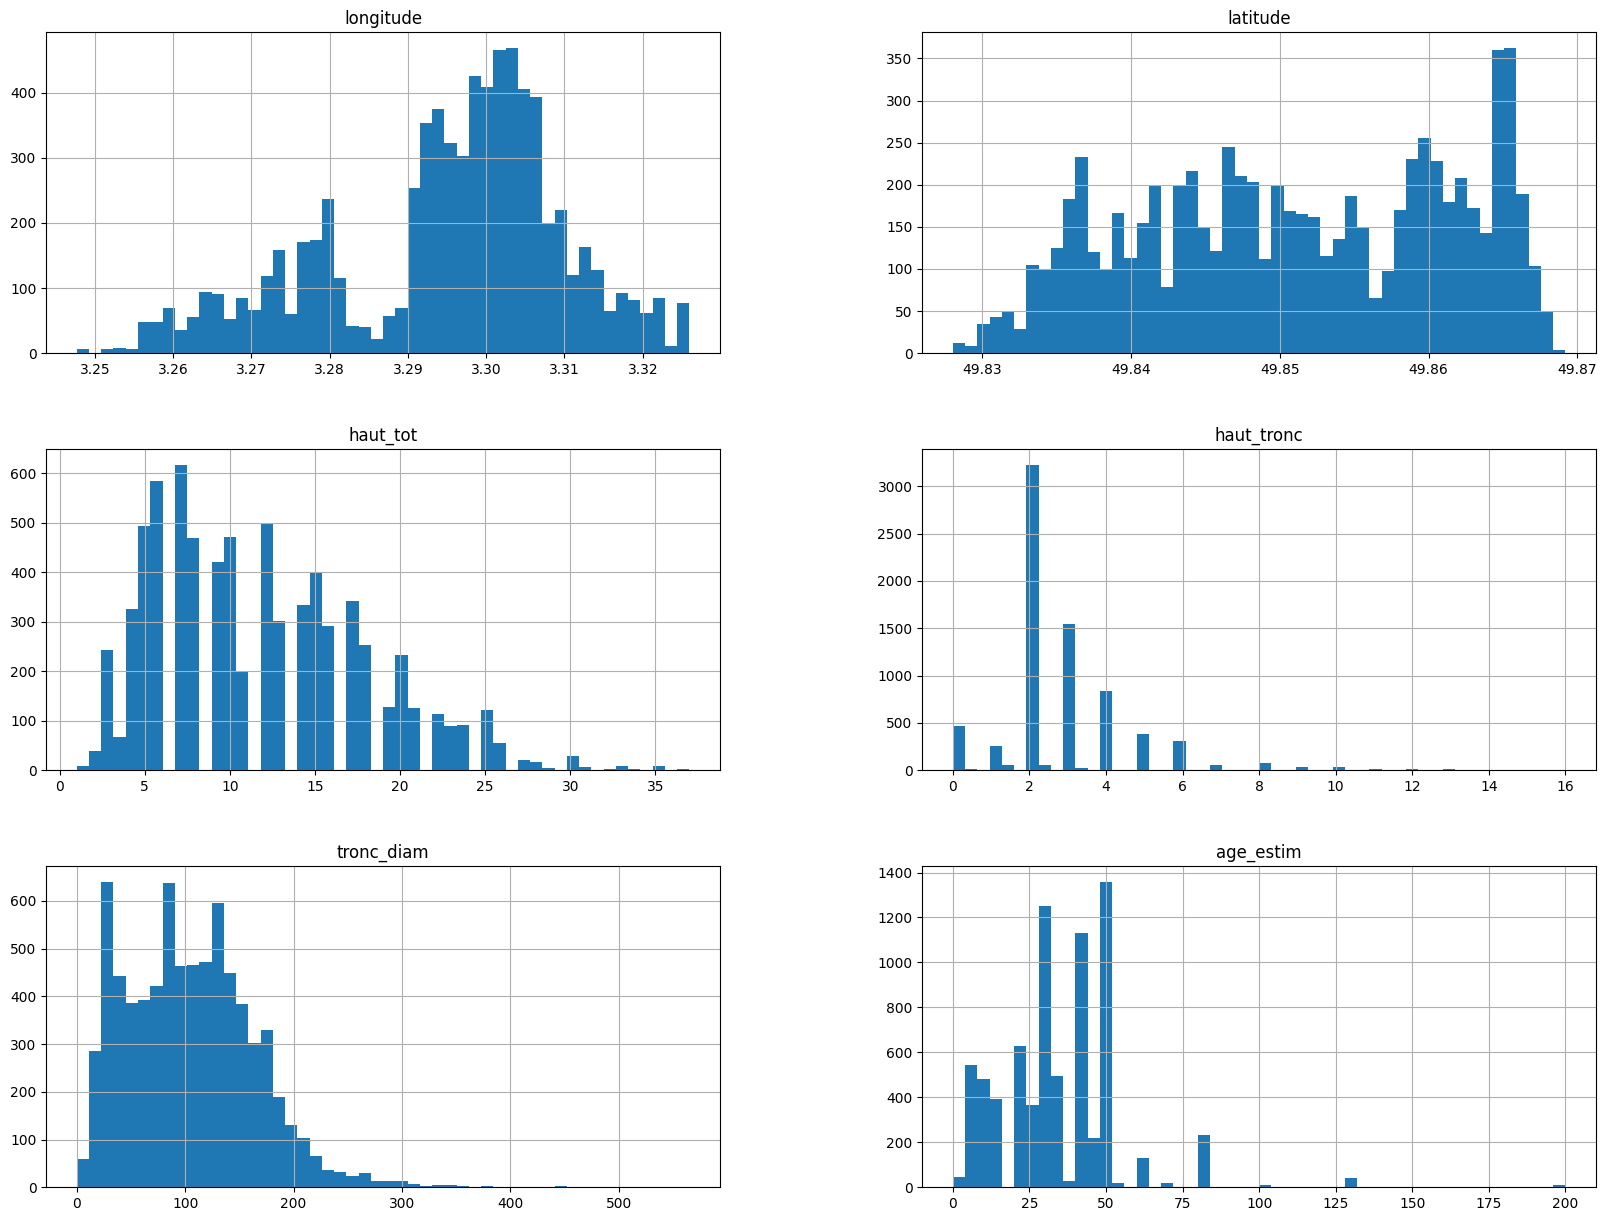

In [9]:
#Extraction des données d’intérêt 
file_arbre = 'Data_Arbre.csv'
arbre = pd.read_csv(file_arbre)

#les colonnes pertinentes
colonnes_pertinentes = ["longitude", "latitude","haut_tot", "haut_tronc", "tronc_diam", 
                        "feuillage", "fk_arb_etat", "age_estim"]
data_arbre = arbre[colonnes_pertinentes].copy() #copie
print(data_arbre.head())  # 5 premiers elements
#data_arbre.describe()

#distributions 
data_arbre.hist(bins=50, figsize=(20,15))



In [10]:
print("Données originales:")
print(data_arbre.head())
ordinal_encoder = OrdinalEncoder()

# Encoder les colonnes catégorielles pertinentes
data_arbre[['feuillage', 'fk_arb_etat']] = ordinal_encoder.fit_transform(data_arbre[['feuillage', 'fk_arb_etat']])

# Afficher les données encodées
print("\nDonnées après encodage ordinal:")
print(data_arbre.head())


Données originales:
   longitude   latitude  haut_tot  haut_tronc  tronc_diam feuillage  \
0   3.293264  49.840500       6.0         2.0        37.0   Feuillu   
1   3.273380  49.861409      13.0         1.0       160.0  Conifère   
2   3.289068  49.844513      12.0         3.0       116.0   Feuillu   
3   3.302387  49.861778      16.0         3.0       150.0   Feuillu   
4   3.304047  49.858446       5.0         2.0       170.0   Feuillu   

  fk_arb_etat  age_estim  
0    EN PLACE       15.0  
1    EN PLACE       50.0  
2    REMPLACÉ       30.0  
3    EN PLACE       50.0  
4    Essouché       40.0  

Données après encodage ordinal:
   longitude   latitude  haut_tot  haut_tronc  tronc_diam  feuillage  \
0   3.293264  49.840500       6.0         2.0        37.0        1.0   
1   3.273380  49.861409      13.0         1.0       160.0        0.0   
2   3.289068  49.844513      12.0         3.0       116.0        1.0   
3   3.302387  49.861778      16.0         3.0       150.0        1.0  

In [11]:
x = data_arbre.drop(columns=['fk_arb_etat']) #features
y = data_arbre['fk_arb_etat'] #target

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x) # normaliser les features

# convertir X_scaled en DataFrame 
x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)

# Afficher les caractéristiques normalisées
print("\nCaractéristiques normalisées:")
print(x_scaled_df.head())

# Afficher la cible
print("\nCible:")
print(y)




Caractéristiques normalisées:
   longitude  latitude  haut_tot  haut_tronc  tronc_diam  feuillage  age_estim
0  -0.121047 -1.027327 -0.920963    -0.46555   -1.148795   0.416219  -0.968413
1  -1.427386  0.976923  0.213100    -1.02441    0.934743  -2.402581   0.822235
2  -0.396705 -0.642658  0.051091     0.09331    0.189412   0.416219  -0.200993
3   0.478338  1.012295  0.699128     0.09331    0.765349   0.416219   0.822235
4   0.587422  0.692942 -1.082973    -0.46555    1.104136   0.416219   0.310621

Cible:
0       1.0
1       1.0
2       4.0
3       1.0
4       2.0
       ... 
7404    1.0
7405    1.0
7406    1.0
7407    1.0
7408    1.0
Name: fk_arb_etat, Length: 7409, dtype: float64


# II - Apprentissage Supervisé pour la régression

In [12]:
# séparation des données et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# mise à l'échelle des caractéristiques (variables explicatives)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)  
x_test_scaled = scaler.transform(x_test)  

## Stochastic Gradient Descent

Scores de précision pour chaque fold : [0.89524291 0.89524291 0.8956962 ]
Précision moyenne : 0.8953940108303865
Matrice de confusion :
 [[   0    7    0    0    0    0]
 [   0 1338    0    0    0    0]
 [   0   25    0    0    0    0]
 [   0    6    0    0    0    0]
 [   0   28    0    0    0    0]
 [   0   78    0    0    0    0]]

Exactitude : 0.902834008097166

Précision : 0.8151092461767935

Rappel : 0.902834008097166

F1-score : 0.8567318459815662
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.90      1.00      0.95      1338
         2.0       0.00      0.00      0.00        25
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00        28
         5.0       0.00      0.00      0.00        78

    accuracy                           0.90      1482
   macro avg       0.15      0.17      0.16      1482
weighted avg       0.82      0.90      0.86      1482

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

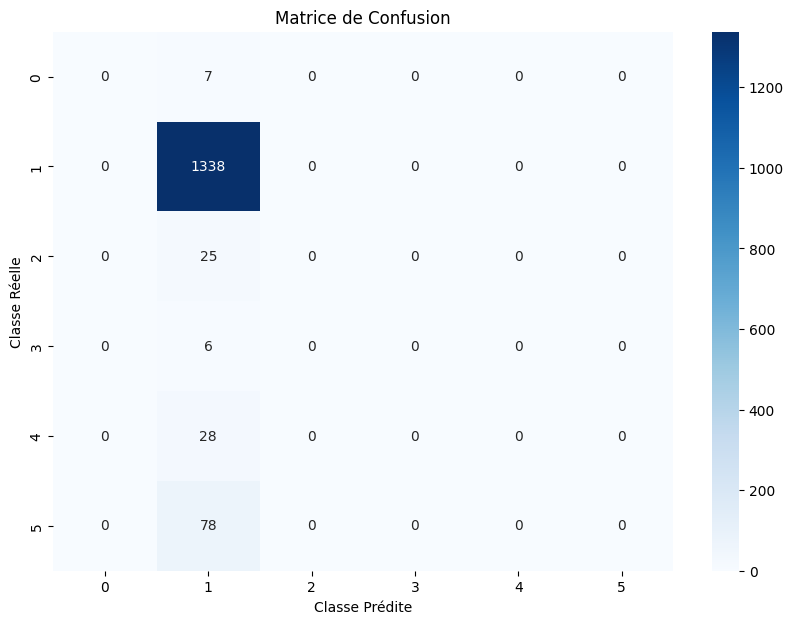

In [15]:

sgd_clf = SGDClassifier()
sgd_clf.fit(x_train_scaled, y_train)  # entraînement du modèle sur les données d'entraînement mises à l'échelle
y_pred = sgd_clf.predict(x_test_scaled)  # prédiction sur l'ensemble de test

matrix = confusion_matrix(y_test, y_pred)  
accuracy = accuracy_score(y_test, y_pred)  # exactitude
# Pour une classification multiclasse, spécifiez le paramètre 'average'
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted') 
precision = precision_score(y_test, y_pred, average='weighted')  

scores = cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')  # cv = nombre de folds pour la validation croisée

print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())

print("Matrice de confusion :\n", matrix)  
print("\nExactitude :", accuracy) 
print("\nPrécision :", precision)  
print("\nRappel :", recall)  
print("\nF1-score :", f1)  
print(classification_report(y_test, y_pred))

#heap matrice
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()

#plot_roc_curve(sgd_clf, x_test, y_pred)
plt.show()
#plot_roc(y_test, y_pred)
plt.show()



## Gradient Boosting Machines

Scores de précision pour chaque fold : [0.89524291 0.89473684 0.8956962 ]
Précision moyenne : 0.895225319872222
Matrice de confusion :
 [[   3    4    0    0    0    0]
 [   2 1324    9    0    3    0]
 [   0   20    2    0    2    1]
 [   0    6    0    0    0    0]
 [   0   24    1    0    3    0]
 [   0   49    0    0    2   27]]

Exactitude : 0.917004048582996

Précision : 0.8997334134574574

Rappel : 0.917004048582996

F1-score : 0.8986117450736866
              precision    recall  f1-score   support

         0.0       0.60      0.43      0.50         7
         1.0       0.93      0.99      0.96      1338
         2.0       0.17      0.08      0.11        25
         3.0       0.00      0.00      0.00         6
         4.0       0.30      0.11      0.16        28
         5.0       0.96      0.35      0.51        78

    accuracy                           0.92      1482
   macro avg       0.49      0.33      0.37      1482
weighted avg       0.90      0.92      0.90      1482


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

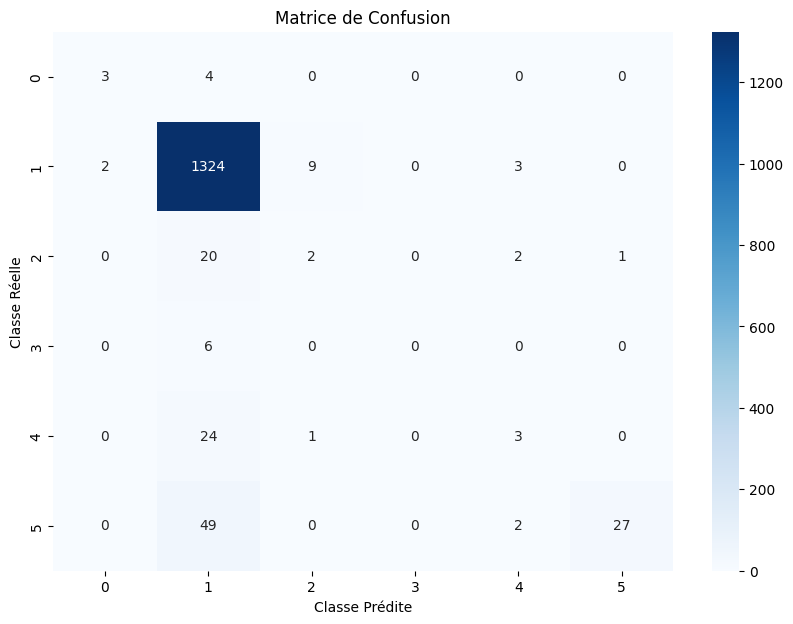

In [16]:
gb_clf = GradientBoostingClassifier()

# Entraîner le modèle sur les données d'entraînement
gb_clf.fit(x_train, y_train)
# prédire sur l'ensemble de test
y_pred = gb_clf.predict(x_test)

matrix = confusion_matrix(y_test, y_pred)  
accuracy = accuracy_score(y_test, y_pred)  # exactitude
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted') 
precision = precision_score(y_test, y_pred, average='weighted')  

scores = cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())

print("Matrice de confusion :\n", matrix)  
print("\nExactitude :", accuracy) 
print("\nPrécision :", precision)  
print("\nRappel :", recall)  
print("\nF1-score :", f1)  
print(classification_report(y_test, y_pred))

#heap matrice
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()



## Support Vector Machines

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scores de précision pour chaque fold : [0.78178138 0.89676113 0.89712434]
Précision moyenne : 0.8585556173200862
Matrice de confusion :
 [[   0    7    0    0    0    0]
 [   0 1338    0    0    0    0]
 [   0   25    0    0    0    0]
 [   0    6    0    0    0    0]
 [   0   28    0    0    0    0]
 [   0   78    0    0    0    0]]

Exactitude : 0.902834008097166

Précision : 0.8151092461767935

Rappel : 0.902834008097166

F1-score : 0.8567318459815662
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.90      1.00      0.95      1338
         2.0       0.00      0.00      0.00        25
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00        28
         5.0       0.00      0.00      0.00        78

    accuracy                           0.90      1482
   macro avg       0.15      0.17      0.16      1482
weighted avg       0.82      0.90      0.86      1482

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

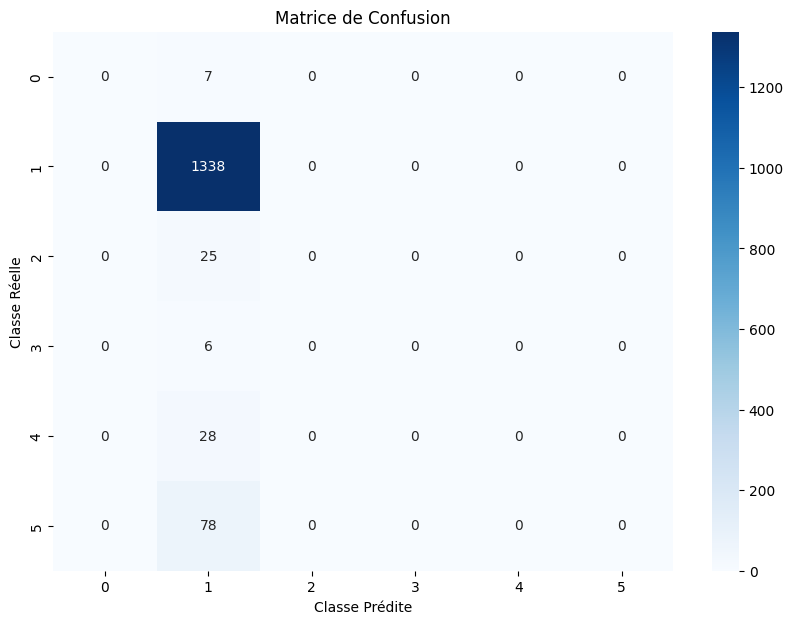

In [17]:
svc_clf = SVC(kernel='rbf')
svc_clf.fit(x_train, y_train)  #entraîner le modèle sur les données d'entraînement
y_pred = svc_clf.predict(x_test) #prédire sur l'ensemble de test


matrix = confusion_matrix(y_test, y_pred)  
accuracy = accuracy_score(y_test, y_pred)  # exactitude
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted') 
precision = precision_score(y_test, y_pred, average='weighted')  

scores = cross_val_score(svc_clf, x_scaled, y, cv=3, scoring='accuracy')  # cv = nombre de folds pour la validation croisée

print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())

print("Matrice de confusion :\n", matrix)  
print("\nExactitude :", accuracy) 
print("\nPrécision :", precision)  
print("\nRappel :", recall)  
print("\nF1-score :", f1)  
print(classification_report(y_test, y_pred))

#heap matrice
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.show()



# III - GridSearchCV

## Stochastic Gradient Descent  

In [ ]:
#Stochastic Gradient Descent  

param_grid_sgd = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
}

grid_search = GridSearchCV(SGDClassifier(), param_grid_sgd, cv=3, scoring='accuracy', verbose=2)


grid_search.fit(x_train, y_train) #entrainement 
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

print("Meilleur score de validation croisée :")
print(grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_sgd = best_model.predict(x_test)

print("Rapport de classification sur l'ensemble de test :")
print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.8s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l2; total time=   0.5s
[CV] END alpha=0.0001,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ..alpha=0.01, loss=hinge, max_iter=1000, penalty=l1; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ..alpha=0.01, loss=hinge, max_iter=1000, penalty=l1; total time=   2.1s
[CV] END ..alpha=0.01, loss=hinge, max_iter=1000, penalty=l1; total time=   1.9s
[CV] END alpha=0.01, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.3s
[CV] END ..alpha=0.01, loss=hinge, max_iter=2000, penalty=l2; total time=   0.6s
[CV] END ..alpha=0.01, loss=hinge, max_iter=2000, penalty=l2; total time=   0.5s
[CV] END ..alpha=0.01, loss=hinge, max_iter=2000, penalty=l2; total time=   0.5s
[CV] END ..alpha=0.01, loss=hinge, max_iter=2000, penalty=l1; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END ..alpha=0.01, loss=hinge, max_iter=2000, penalty=l1; total time=   3.8s
[CV] END ..alpha=0.01, loss=hinge, max_iter=2000, penalty=l1; total time=   2.1s
[CV] END alpha=0.01, loss=hinge, max_iter=2000, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, loss=hinge, max_iter=2000, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, loss=hinge, max_iter=2000, penalty=elasticnet; total time=   0.4s
[CV] END ..alpha=0.01, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END ..alpha=0.01, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END ..alpha=0.01, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END ..alpha=0.01, loss=hinge, max_iter=3000, penalty=l1; total time=   0.9s
[CV] END ..alpha=0.01, loss=hinge, max_iter=3000, penalty=l1; total time=   0.5s
[CV] END ..alpha=0.01, loss=hinge, max_iter=3000, penalty=l1; total time=   1.2s
[CV] END alpha=0.01, loss=hinge, max_iter=3000, penalty=elasticnet; total time=   0.4s
[CV]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, loss=modified_huber, max_iter=1000, penalty=l1; total time=   2.1s
[CV] END alpha=0.01, loss=modified_huber, max_iter=1000, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, loss=modified_huber, max_iter=1000, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.01, loss=modified_huber, max_iter=1000, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, loss=modified_huber, max_iter=2000, penalty=l2; total time=   0.6s
[CV] END alpha=0.01, loss=modified_huber, max_iter=2000, penalty=l2; total time=   0.6s
[CV] END alpha=0.01, loss=modified_huber, max_iter=2000, penalty=l2; total time=   0.6s
[CV] END alpha=0.01, loss=modified_huber, max_iter=2000, penalty=l1; total time=   1.3s
[CV] END alpha=0.01, loss=modified_huber, max_iter=2000, penalty=l1; total time=   0.5s
[CV] END alpha=0.01, loss=modified_huber, max_iter=2000, penalty=l1; total time=   0.5s
[CV] END alpha=0.01, loss=modified_huber, max_iter=2000, penalty=elasticnet; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, loss=modified_huber, max_iter=3000, penalty=l1; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, loss=modified_huber, max_iter=3000, penalty=l1; total time=   5.5s
[CV] END alpha=0.01, loss=modified_huber, max_iter=3000, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.01, loss=modified_huber, max_iter=3000, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, loss=modified_huber, max_iter=3000, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0.01, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0.01, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.5s
[CV] END alpha=0.01, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.9s
[CV] END alpha=0.01, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   1.0s
[CV] END alpha=0.01, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   1.0s
[CV] END alpha=0.01, loss=squared_hinge, max_iter=1000, penalty=elasticnet; total time=   1.1s
[CV] EN

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
81 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

Meilleurs paramètres trouvés :
{'alpha': 0.0001, 'loss': 'modified_huber', 'max_iter': 3000, 'penalty': 'l1'}
Meilleur score de validation croisée :
0.8987692820171168
Rapport de classification sur l'ensemble de test :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.94      0.88      0.91      1338
         2.0       0.07      0.28      0.11        25
         3.0       0.00      0.00      0.00         6
         4.0       0.38      0.21      0.27        28
         5.0       0.28      0.37      0.32        78

    accuracy                           0.82      1482
   macro avg       0.28      0.29      0.27      1482
weighted avg       0.87      0.82      0.84      1482



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Gradient Boosting Machines


In [ ]:
#Gradient Boosting Machines

param_grid_gbc = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.001],
    'min_samples_split': [2, 3, 1],
    'min_samples_leaf': [1, 2]

}

grid_search_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid_gbc, cv=3, scoring='accuracy', verbose=2)

grid_search_gbc.fit(x_train, y_train) #entrainement 
print("Meilleurs paramètres trouvés :")
print(grid_search_gbc.best_params_)

print("Meilleur score de validation croisée :")
print(grid_search_gbc.best_score_)

best_model_gbc = grid_search_gbc.best_estimator_
y_pred_gbc = best_model_gbc.predict(x_test)
print("Rapport de classification sur l'ensemble de test :")
print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

Meilleurs paramètres trouvés :
{'learning_rate': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
Meilleur score de validation croisée :
0.9203646287090658
Rapport de classification sur l'ensemble de test :
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.90      1.00      0.95      1338
         2.0       0.00      0.00      0.00        25
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00        28
         5.0       0.00      0.00      0.00        78

    accuracy                           0.90      1482
   macro avg       0.15      0.17      0.16      1482
weighted avg       0.82      0.90      0.86      1482



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Support Vector Machines


In [19]:

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'], 
    'degree':

}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='accuracy', verbose=2)


grid_search_svm.fit(x_train, y_train) #entrainement 
print("Meilleurs paramètres trouvés :")
print(grid_search_svm.best_params_)

print("Meilleur score de validation croisée :")
print(grid_search_svm.best_score_)

best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(x_test)
classe = classification_report(y_test, y_pred)

print("Rapport de classification sur l'ensemble de test :", classe)



Fitting 3 folds for each of 12 candidates, totalling 36 fits


# IV - Préparation du Script 

In [ ]:
def charger_modele(nom_fichier):
    with open(nom_fichier, 'rb') as fichier_modele:
        modele_charge = pickle.load(fichier_modele)
    return modele_charge


modele = charger_modele('.pkl')
donnees_test = [...]  
resultat = modele.predict(donnees_test)
print(resultat)


FileNotFoundError: [Errno 2] No such file or directory: 'modele_enregistre.pkl'

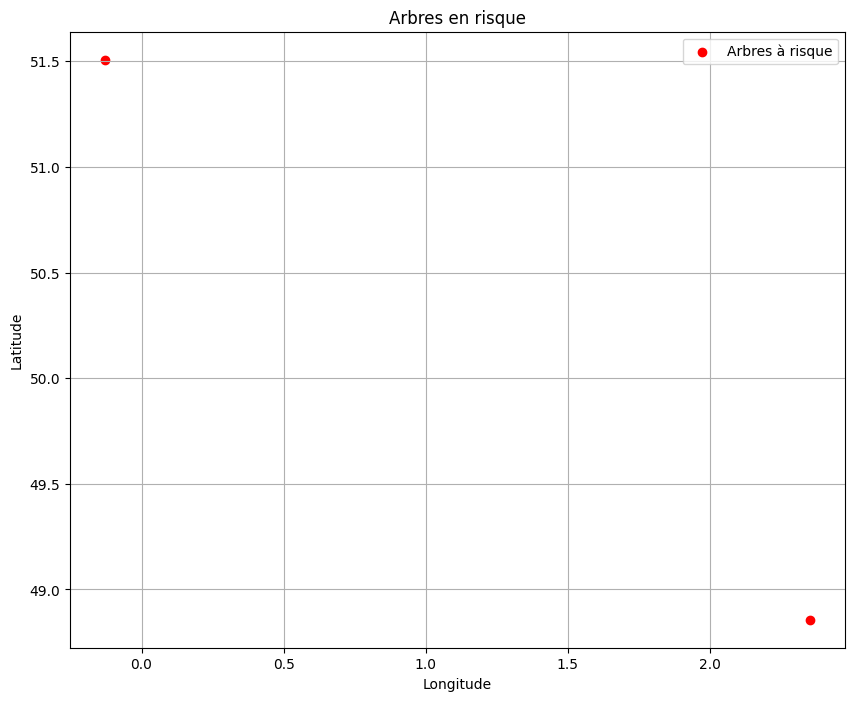

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json

data_json = '''
[
    {"latitude": 48.8566, "longitude": 2.3522},
    {"latitude": 51.5074, "longitude": -0.1278}
]
'''

data = json.loads(data_json) # charger les données JSON en tant qu'objet Python
df = pd.DataFrame(data)

def afficher_arbres_risques(dataframe):
    plt.figure(figsize=(10, 8))
    plt.scatter(dataframe['longitude'], dataframe['latitude'], color='red', marker='o', label='Arbres à risque')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Arbres en risque')
    plt.legend()
    
    # Afficher le plot
    plt.grid(True)
    plt.show()

afficher_arbres_risques(df)
